# Fraud Detection with Ethereum Data

This tutorial demonstrates how to predict fraudulent accounts on a transaction network between the accounts. It uses the `featurizer` in [pyTigerGraph](https://docs.tigergraph.com/pytigergraph/current/intro/) to engineer graph features from the transaction graph, the data loaders in pyTigerGraph to pull data from the TigerGraph database, [xgboost](https://xgboost.readthedocs.io/en/stable/) to build a gradient boost tree model, and [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/) to build GNN models.

The data used here are transactions on the Ethereum platform, which comprise a transaction graph of Ether, the second largest cryptocurrency.  Vertices in the graph are wallets (i.e., accounts) on the platform, and edges are transactiosn between the accounts. See below for the schema of this graph. There are 32,168 vertices and 84,088 edges. The dataset is derived from the public Ethereum dataset from [XBlock](https://xblock.pro/ethereum#/dataset/13).

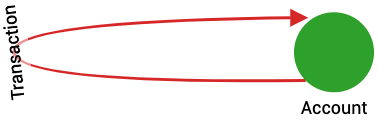

Conclusion
1. Graph features boost traditional ML model performance. PageRank has the high feature importance score in the xgboost example above.
1. GAT achieves higher accuracy and precision than xgboost.  
2. GAT achieves slightly lower but still good recall compared to xgboost.

## Database Preparation

The `TigerGraphConnection` class represents a connection to the TigerGraph database. Under the hood, it stores the necessary information to communicate with the database. It is able to perform quite a few database tasks. Please see its [documentation](https://docs.tigergraph.com/pytigergraph/current/intro/) for details.

To connect your database, modify the `config.json` file accompanying this notebook. Set the value of `getToken` based on whether token auth is enabled for your database. Token auth is always enabled for tgcloud databases.

In [2]:
from pyTigerGraph import TigerGraphConnection
import json

# Read in DB configs
with open('../../config.json', "r") as config_file:
    config = json.load(config_file)
    
conn = TigerGraphConnection(
    host=config["host"],
    username=config["username"],
    password=config["password"]
)

Download Ethereum dataset and ingest it to the database.

In [3]:
from pyTigerGraph.datasets import Datasets

dataset = Datasets("Ethereum")

conn.ingestDataset(dataset, getToken=config["getToken"])

A folder with name Ethereum already exists in ./tmp. Skip downloading.
---- Checking database ----
A graph with name Ethereum already exists in the database. Skip ingestion.
Graph name is set to Ethereum for this connection.


Visualize schema

In [4]:
from pyTigerGraph.visualization import drawSchema

drawSchema(conn.getSchema(force=True))

CytoscapeWidget(cytoscape_layout={'name': 'circle', 'animate': True, 'padding': 1}, cytoscape_style=[{'selecto…

## Graph Feature Engineering

The [featurizer](https://docs.tigergraph.com/pytigergraph/current/gds/featurizer) in pyTigerGraph contains 30+ graph algorithms for calculating graph features. You can also use your own graph queries with it. Here we use the built-in pagerank and FastRP algorithms as well as write our own queries for customized features.

In [5]:
f = conn.gds.featurizer()

### PageRank

In [6]:
import pandas as pd

tg_pagerank_params = {
  "v_type": "Account",
  "e_type": "Transaction",
  "result_attribute": "pagerank",
  "top_k":5  
}
results = f.runAlgorithm("tg_pagerank", tg_pagerank_params)

pd.json_normalize(results[0]['@@top_scores_heap'])

,Vertex_ID,score
0,0x903bb9cd3a276d8f18fa6efed49b9bc52ccf06e5,741.66101
1,0x47779ea9849c7eec04197b21f9554931b8fcd5f4,607.41815
2,0xbfa82fbe0e66d8e2b7dcc16328db9ecd70533d13,212.12238
3,0x3cbd2e6143f057bd49ffb4c7058217a5900c35d3,179.57887
4,0x5df65e16d6ec1a8090ffa11c8185ad372a8786cd,173.81029


### Degree Features

In [7]:
f.installAlgorithm("degrees", query_path="./gsql/degrees.gsql")

f.runAlgorithm("degrees", custom_query=True)

[{'Status': 'Degrees computed Successfully'}]

### Amount Features

In [8]:
f.installAlgorithm("amounts", query_path="./gsql/amounts.gsql")

f.runAlgorithm("amounts", custom_query=True)

[{'Status': 'Amounts computed successfully'}]

### FastRP Embeddings

In [9]:
params={"v_type": ["Account"],
        "e_type": ["Transaction", "reverse_Transaction"],
        "output_v_type": ["Account"],
        "iteration_weights": "1,2,4",
        "beta": -0.1,
        "embedding_dimension": 128,
        "embedding_dim_map": [],
        "default_length": 128,
        "sampling_constant": 3,
        "random_seed": 42,
        "component_attribute": "",
        "result_attribute": "embedding",
        "choose_k": 0}

f.runAlgorithm("tg_fastRP", params=params)

[{'@@embedding_dim_map': {'default': {'min_dim': 0,
    'max_dim': 128,
    'weight': 1}}},
 {'sample_verts': []}]

### Check Labels

In [10]:
frauds = conn.getVertexCount("Account", "is_fraud = 1") 
nonfrauds = conn.getVertexCount("Account", "is_fraud = 0") 
print("Fraud accounts: {} ({:.2f}%%)".format(frauds, frauds/(frauds+nonfrauds)*100))
print("Normal accounts: {} ({:.2f}%%)".format(nonfrauds, nonfrauds/(frauds+nonfrauds)*100))

Fraud accounts: 1165 (3.62%%)
Normal accounts: 31003 (96.38%%)


## Traditional ML with Graph Features

### Train/Test Split

In [11]:
split = conn.gds.vertexSplitter(is_training=0.8, is_validation=0.2)

In [12]:
split.run()

Splitting vertices...
Vertex split finished successfully.


### Load data

Create Vertex Loaders

In [1]:
import numpy as np

def process_embedding(df):
    def helper(x):
        try:  # some unconnected vertices will not have a valid embedding, fill with 0s if that is the case.
            return np.array(x["embedding"].split(" ")[:-1], dtype=np.float64)
        except:
            return np.zeros(128)
    df["embedding"] = df.apply(lambda x: helper(x), axis=1)
    emb_df = pd.DataFrame(df["embedding"].tolist()).add_prefix("emb")
    df.drop(columns=["embedding"], inplace=True)
    df = df.join(emb_df)
    return df

In [14]:
train_loader = conn.gds.vertexLoader(
    attributes=["in_degree","out_degree","send_amount","send_min",
                "recv_amount","recv_min","pagerank", "is_fraud", "embedding"],
    num_batches=1,
    filter_by="is_training",
    callback_fn = lambda x: process_embedding(x)
)

In [15]:
valid_loader = conn.gds.vertexLoader(
    attributes=["in_degree","out_degree","send_amount","send_min",
                "recv_amount","recv_min","pagerank", "is_fraud", "embedding"],
    num_batches=1,
    filter_by="is_validation",
    callback_fn = lambda x: process_embedding(x)
)

Get train/valid data

In [16]:
train_data = train_loader.data
train_data.head()

,vid,in_degree,out_degree,send_amount,send_min,recv_amount,recv_min,pagerank,is_fraud,emb0,...,emb118,emb119,emb120,emb121,emb122,emb123,emb124,emb125,emb126,emb127
0,234881025,8,1,0.19912,0.19912,0.71332,0.00426,1.051000,1,-0.047130,...,0.045751,0.009796,0.246114,0.135275,0.188289,0.145758,0.163340,-0.540732,-0.009876,0.114094
1,234881026,5,2,10.69120,3.69118,9.99248,0.50000,0.667945,1,-0.056560,...,-0.335258,-0.067109,-0.294415,-0.028373,-0.181596,-0.340700,0.238586,-0.199453,-0.000079,0.008715
2,234881027,9,2,10.77360,3.77460,10.67570,0.04306,0.985464,1,0.174347,...,-0.112702,-0.049264,0.064580,0.165827,-0.235902,-0.225494,-0.329536,-0.065534,-0.223186,0.042215
3,234881028,10,9,441.30000,0.05000,188.48900,0.37828,0.867988,1,0.170441,...,0.166607,-0.230478,0.456073,0.023082,0.065435,0.134760,-0.182918,0.130709,0.204439,0.003432
4,234881029,1,1,6.99000,6.99000,7.00000,7.00000,0.277500,1,0.000000,...,0.190411,0.190411,0.060774,0.000000,0.060774,0.000000,-0.190411,0.251185,0.000000,-0.251185


In [17]:
valid_data = valid_loader.data
valid_data.head()

,vid,in_degree,out_degree,send_amount,send_min,recv_amount,recv_min,pagerank,is_fraud,emb0,...,emb118,emb119,emb120,emb121,emb122,emb123,emb124,emb125,emb126,emb127
0,234881024,1,1,0.51914,0.51914,0.52000,0.52000,0.155100,1,-0.107753,...,-0.374269,-0.144818,-0.134207,-0.160478,-0.024463,0.171150,0.311766,0.307944,-0.247571,0.189567
1,234881033,9,6,31.68790,0.07000,24.90020,0.07000,1.371310,1,-0.125151,...,-0.090309,0.323673,0.096190,-0.175554,-0.273964,0.237006,-0.245389,-0.067310,-0.088549,0.056987
2,234881039,8,1,39.30500,39.30500,39.30540,0.08309,1.170000,1,-0.281923,...,0.000000,-0.281923,-0.501023,-0.219100,-0.375897,-0.313074,-0.187948,0.093974,0.093974,-0.281923
3,234881041,4,1,7.68433,7.68433,7.68519,0.50000,0.445214,1,0.174309,...,-0.046449,-0.021162,0.058503,-0.172840,-0.238037,0.183829,-0.292503,-0.119214,0.102231,0.217926
4,234881043,2,0,0.00000,0.00000,0.00000,0.00000,1.000000,1,0.014363,...,0.448090,0.179457,0.054849,0.184936,0.061575,-0.015394,0.154578,0.014534,-0.151962,0.154064


### Create xgboost model

In [18]:
from xgboost import XGBClassifier

tree_model = XGBClassifier(
    nthread=-1, n_estimators=100, learning_rate=0.1, 
    objective='binary:logistic', max_depth=2, scale_pos_weight=400, 
    min_child_weight=80, gamma = 10, max_delta_step=2) 

### Train xgboost model - No Embeddings

In [19]:
features = ["in_degree","out_degree","send_amount","send_min",
            "recv_amount","recv_min","pagerank"]
# Train model
tree_model.fit(train_data[features], train_data["is_fraud"])


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=10, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=2,
              max_depth=2, max_leaves=0, min_child_weight=80, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              nthread=-1, num_parallel_tree=1, predictor='auto', ...)

### Evaluate model

In [20]:
from pyTigerGraph.gds.metrics import Accuracy, BinaryPrecision, BinaryRecall
from collections import defaultdict

# Get predictions
pred = tree_model.predict(valid_data[features].values)
# Get prediction scores for later use
yhat_tree = tree_model.predict_proba(valid_data[features].values)[:,1]
ytrue_tree = valid_data["is_fraud"].values

metrics = defaultdict(list)
m = Accuracy()
m.update(pred, ytrue_tree)
metrics["acc_tree"].append(m.value)

m = BinaryPrecision()
m.update(pred, ytrue_tree)
metrics["prec_tree"].append(m.value)

m = BinaryRecall()
m.update(pred, ytrue_tree)
metrics["rec_tree"].append(m.value)

print("Accuracy {:.4f}, Precision {:.4f}, Recall {:.4f}".format(
    metrics["acc_tree"][-1], metrics["prec_tree"][-1], metrics["rec_tree"][-1]))

Accuracy 0.7567, Precision 0.1271, Recall 1.0000


### Add FastRP Embeddings to XGBoost Model

In [21]:
emb_tree_model = XGBClassifier(
    nthread=-1, n_estimators=100, learning_rate=0.1, 
    objective='binary:logistic', max_depth=2, scale_pos_weight=400, 
    min_child_weight=80, gamma = 10, max_delta_step=2) 

features = ["in_degree","out_degree","send_amount","send_min",
            "recv_amount","recv_min","pagerank"] + [x for x in train_data.columns if "emb" in x]
# Train model
emb_tree_model.fit(train_data[features], train_data["is_fraud"])


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=10, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=2,
              max_depth=2, max_leaves=0, min_child_weight=80, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              nthread=-1, num_parallel_tree=1, predictor='auto', ...)

In [22]:
from pyTigerGraph.gds.metrics import Accuracy, BinaryPrecision, BinaryRecall
from collections import defaultdict

# Get predictions
pred = emb_tree_model.predict(valid_data[features].values)
# Get prediction scores for later use
yhat_tree = emb_tree_model.predict_proba(valid_data[features].values)[:,1]
ytrue_tree = valid_data["is_fraud"].values

m = Accuracy()
m.update(pred, ytrue_tree)
metrics["acc_fastrp_tree"].append(m.value)

m = BinaryPrecision()
m.update(pred, ytrue_tree)
metrics["prec_fastrp_tree"].append(m.value)

m = BinaryRecall()
m.update(pred, ytrue_tree)
metrics["rec_fastrp_tree"].append(m.value)

print("Accuracy {:.4f}, Precision {:.4f}, Recall {:.4f}".format(
    metrics["acc_fastrp_tree"][-1], metrics["prec_fastrp_tree"][-1], metrics["rec_fastrp_tree"][-1]))

Accuracy 0.8900, Precision 0.2425, Recall 0.9912


### Explain models
Here, we are going to look at the feature importance values of both of the XGBoost models. For the model trained on the FastRP embeddings, we summed all dimensions of the embedding into one feature importance score. One can see that the embedding contributes heavily to the model's performance.

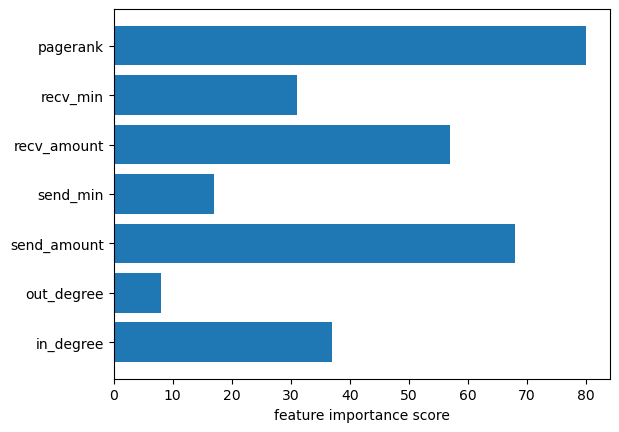

In [23]:
import matplotlib.pyplot as plt

feature_importance = tree_model.get_booster().get_fscore()

plt.barh(range(len(feature_importance)), feature_importance.values());
plt.yticks(range(len(feature_importance)), feature_importance.keys());
plt.xlabel("feature importance score");

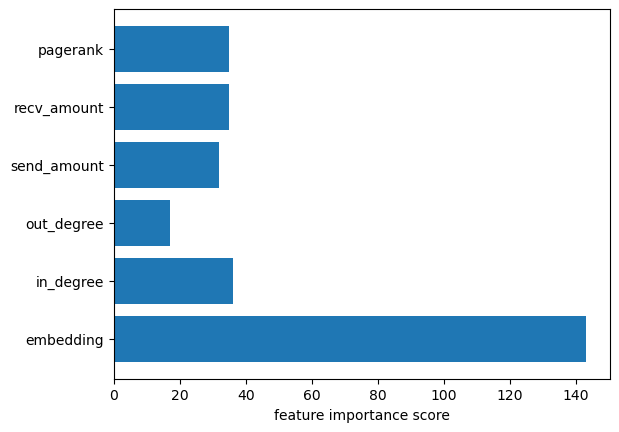

In [24]:
import matplotlib.pyplot as plt

feature_importance = emb_tree_model.get_booster().get_fscore()

condensed_feat_imp = {"embedding": 0}
for feat in feature_importance.keys():
    if "emb" in feat:
        condensed_feat_imp["embedding"] += feature_importance[feat]
    else:
        condensed_feat_imp[feat] = feature_importance[feat]

plt.barh(range(len(condensed_feat_imp)), condensed_feat_imp.values());
plt.yticks(range(len(condensed_feat_imp)), condensed_feat_imp.keys());
plt.xlabel("feature importance score");

## Graph Neural Network

Hyperparameters for the model and training environment

In [25]:
hp = {
    "batch_size": 1024, 
    "num_neighbors": 200, 
    "num_hops": 3, 
    "hidden_dim": 256, 
    "num_layers": 2, 
    "dropout": 0.05, 
    "lr": 0.0075, 
    "l2_penalty": 5e-5
}

### Create Neighbor Loaders

Neighbor loaders for training and validation.

In [26]:
train_loader = conn.gds.neighborLoader(
    v_in_feats=["in_degree","out_degree","send_amount","send_min","recv_amount","recv_min","pagerank"],
    v_out_labels=["is_fraud"],
    v_extra_feats=["is_training", "is_validation"],
    output_format="PyG",
    batch_size=hp["batch_size"],
    num_neighbors=hp["num_neighbors"],
    num_hops=hp["num_hops"],
    filter_by = "is_training",
    shuffle=True,
    timeout=600000
)

In [27]:
valid_loader = conn.gds.neighborLoader(
    v_in_feats=["in_degree","out_degree","send_amount","send_min","recv_amount","recv_min","pagerank"],
    v_out_labels=["is_fraud"],
    v_extra_feats=["is_training", "is_validation"],
    output_format="PyG",
    batch_size=hp["batch_size"],
    num_neighbors=hp["num_neighbors"],
    num_hops=hp["num_hops"],
    filter_by = "is_validation",
    shuffle=False,
    timeout=600000
)

### Create Graph Attention Network

In [28]:
import torch
from torch_geometric.nn import GAT

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GAT(
    in_channels=7,
    hidden_channels=hp["hidden_dim"],
    num_layers=hp["num_layers"],
    out_channels=2,
    heads=8,
    dropout=hp["dropout"],
).to(device)

optimizer = torch.optim.Adam(
    model.parameters(), lr=hp["lr"], weight_decay=hp["l2_penalty"]
)

### Train Model

In [29]:
import torch_geometric.transforms as T
import torch.nn.functional as F
from pyTigerGraph.gds.metrics import Accumulator
from tqdm.notebook import trange, tqdm

metrics["loss_gnn_train"]=[] 
metrics["acc_gnn_train"]=[] 
metrics["prec_gnn_train"]=[] 
metrics["rec_gnn_train"]=[]
metrics["loss_gnn_val"]=[]
metrics["acc_gnn_val"]=[]
metrics["prec_gnn_val"]=[]
metrics["rec_gnn_val"]=[]
epoch_bar = trange(10, unit="epoch", bar_format = "Epoch {n_fmt}/{total_fmt} |{bar}| [{elapsed},{rate_fmt}]{postfix}")
for epoch in epoch_bar:
    # print("Epoch {}".format(epoch), flush=True)
    # Train
    model.train()
    epoch_train_loss = Accumulator()
    epoch_train_acc = Accuracy()
    epoch_train_prec = BinaryPrecision()
    epoch_train_rec = BinaryRecall()
    
    # Iterate through the loader to get a stream of subgraphs instead of the whole graph
    batch_bar = tqdm(train_loader, total=train_loader.num_batches, unit="batch", leave=False,
                     bar_format = "Train Batch {n_fmt}/{total_fmt} |{bar}| [{elapsed},{rate_fmt}]{postfix}")
    for batch in batch_bar:
        batchsize = int(batch.is_seed.sum())
        norm = T.NormalizeFeatures()
        batch = norm(batch).to(device)
       
        # Forward pass
        out = model(batch.x.float(), batch.edge_index, batch.edge_weight)
        # Calculate loss
        class_weight = torch.FloatTensor([1.0, 15.0])
        loss = F.cross_entropy(out[batch.is_seed], batch.y[batch.is_seed].long(), class_weight)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_train_loss.update(loss.item() * batchsize, batchsize)
        # Predict on training data
        with torch.no_grad():
            pred = out.argmax(dim=1)
            epoch_train_acc.update(pred[batch.is_seed], batch.y[batch.is_seed])
            epoch_train_prec.update(pred[batch.is_seed], batch.y[batch.is_seed])
            epoch_train_rec.update(pred[batch.is_seed], batch.y[batch.is_seed])            
        # Log training status after each batch
        metrics["loss_gnn_train"].append(epoch_train_loss.mean)
        metrics["acc_gnn_train"].append(float(epoch_train_acc.value))
        metrics["prec_gnn_train"].append(float(epoch_train_prec.value) if epoch_train_prec.value else 0)
        metrics["rec_gnn_train"].append(float(epoch_train_rec.value) if epoch_train_rec.value else 0)
        # print(
        #     "  Train batch {}, loss {:.4f}, accuracy {:.4f}, precision {:.4f}, recall {:.4f}".format(
        #         bid, metrics["loss_gnn_train"][-1], 
        #         metrics["acc_gnn_train"][-1], 
        #         metrics["prec_gnn_train"][-1], 
        #         metrics["rec_gnn_train"][-1]
        #     )
        # )
    batch_bar.close()
    # Evaluate
    model.eval()
    epoch_val_loss = Accumulator()
    epoch_val_prec = BinaryPrecision()
    epoch_val_rec = BinaryRecall()
    epoch_val_acc = Accuracy()
    yhat_gat = []
    ytrue_gat = []
    
    batch_bar = tqdm(valid_loader, total=valid_loader.num_batches, unit="batch", leave=False,
                     bar_format = "Valid {n_fmt}/{total_fmt} |{bar}| [{elapsed},{rate_fmt}]{postfix}")
    for batch in batch_bar:
        batchsize = int(batch.is_seed.sum())
        norm = T.NormalizeFeatures()
        batch = norm(batch).to(device)
        with torch.no_grad():
            # Forward pass
            out = model(batch.x.float(), batch.edge_index)   
            # Calculate loss
            class_weight = torch.FloatTensor([1.0, 20.0])
            valid_loss = F.cross_entropy(out[batch.is_seed], batch.y[batch.is_seed].long(), class_weight)
            epoch_val_loss.update(valid_loss.item() * batchsize, batchsize)
            # Prediction
            pred = out.argmax(dim=1)
            epoch_val_acc.update(pred[batch.is_seed], batch.y[batch.is_seed])
            epoch_val_prec.update(pred[batch.is_seed], batch.y[batch.is_seed])
            epoch_val_rec.update(pred[batch.is_seed], batch.y[batch.is_seed])
            yhat_gat.extend(F.softmax(out[batch.is_seed], dim=1)[:,1].tolist())
            ytrue_gat.extend(batch.y[batch.is_seed].tolist())
    batch_bar.close()

    # Log testing result after each epoch
    metrics["loss_gnn_val"].append(epoch_val_loss.mean)
    metrics["acc_gnn_val"].append(float(epoch_val_acc.value))
    metrics["prec_gnn_val"].append(float(epoch_val_prec.value) if epoch_val_prec.value else 0)
    metrics["rec_gnn_val"].append(float(epoch_val_rec.value) if epoch_val_rec.value else 0)
    epoch_bar.set_postfix(Loss=metrics["loss_gnn_val"][-1],
                          Accuracy=metrics["acc_gnn_val"][-1],
                          Precision=metrics["prec_gnn_val"][-1],
                          Recall=metrics["rec_gnn_val"][-1])
epoch_bar.close()

Epoch 0/10 |          | [00:00,?epoch/s]

Train Batch 0/26 |          | [00:00,?batch/s]

Valid 0/7 |          | [00:00,?batch/s]

Train Batch 0/26 |          | [00:00,?batch/s]

Valid 0/7 |          | [00:00,?batch/s]

Train Batch 0/26 |          | [00:00,?batch/s]

Valid 0/7 |          | [00:00,?batch/s]

Train Batch 0/26 |          | [00:00,?batch/s]

Valid 0/7 |          | [00:00,?batch/s]

Train Batch 0/26 |          | [00:00,?batch/s]

Valid 0/7 |          | [00:00,?batch/s]

Train Batch 0/26 |          | [00:00,?batch/s]

Valid 0/7 |          | [00:00,?batch/s]

Train Batch 0/26 |          | [00:00,?batch/s]

Valid 0/7 |          | [00:00,?batch/s]

Train Batch 0/26 |          | [00:00,?batch/s]

Valid 0/7 |          | [00:00,?batch/s]

Train Batch 0/26 |          | [00:00,?batch/s]

Valid 0/7 |          | [00:00,?batch/s]

Train Batch 0/26 |          | [00:00,?batch/s]

Valid 0/7 |          | [00:00,?batch/s]

In [ ]:
# Print the final performance metric for the GNN model
print("Accuracy {:.4f}, Precision {:.4f}, Recall {:.4f}".format(
    metrics["acc_gnn_val"][-1], metrics["prec_gnn_val"][-1], metrics["rec_gnn_val"][-1]))

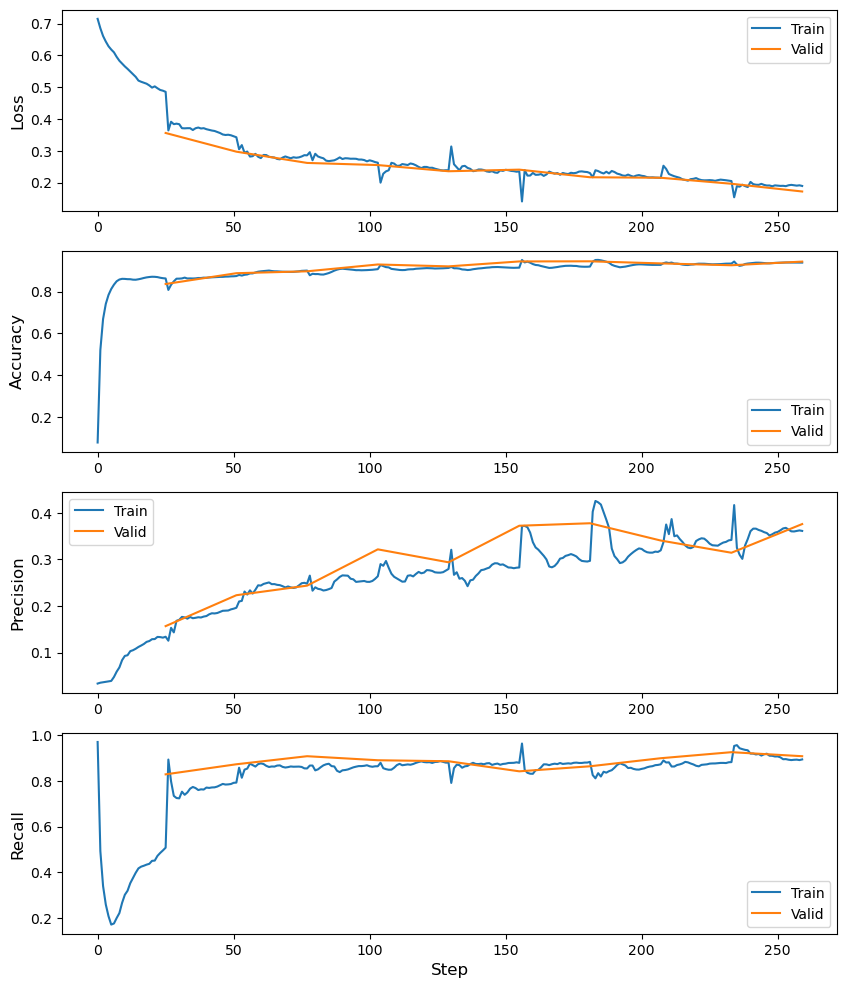

In [30]:
fix,ax = plt.subplots(4,1, figsize=(10,12))
step = int(len(metrics["loss_gnn_train"])/len(metrics["loss_gnn_val"]))
x = range(step-1, len(metrics["loss_gnn_train"]), step)
ax[0].plot(metrics["loss_gnn_train"], label="Train");
ax[0].plot(x, metrics["loss_gnn_val"], label="Valid");
ax[0].set_ylabel("Loss", fontsize=12)
ax[0].legend()
ax[1].plot(metrics["acc_gnn_train"], label="Train");
ax[1].plot(x, metrics["acc_gnn_val"], label="Valid");
ax[1].set_ylabel("Accuracy", fontsize=12)
ax[1].legend()
ax[2].plot(metrics["prec_gnn_train"], label="Train");
ax[2].plot(x, metrics["prec_gnn_val"], label="Valid");
ax[2].set_ylabel("Precision", fontsize=12);
ax[2].legend()
ax[3].plot(metrics["rec_gnn_train"], label="Train");
ax[3].plot(x, metrics["rec_gnn_val"], label="Valid");
ax[3].legend()
ax[3].set_ylabel("Recall", fontsize=12);
ax[3].set_xlabel("Step", fontsize=12);

### Explain Model

Sample a random vertex that is predicted to be fraudulent and visualize
the subgraph around it.

Explain node 53: 100%|██████████| 100/100 [00:00<00:00, 285.03it/s]


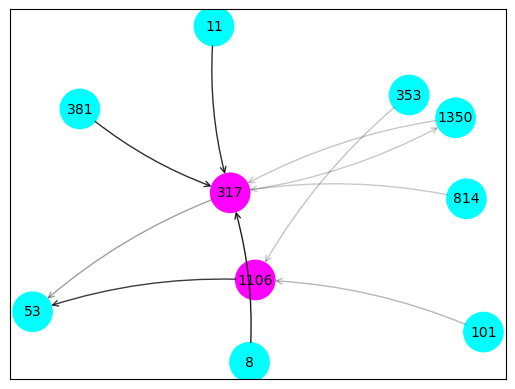

In [38]:
import numpy as np
from torch_geometric.nn import GNNExplainer

node_idx = int(np.random.choice((pred*batch.is_seed).numpy().nonzero()[0]))
x, edge_index = batch.x.float(), batch.edge_index
explainer = GNNExplainer(model, epochs=100)
node_feat_mask, edge_mask = explainer.explain_node(
    node_idx, x, edge_index)
ax, G = explainer.visualize_subgraph(
    node_idx, edge_index, edge_mask, y = batch.y)

Using the sampled vertex from above, view the features that contribut most to the prediction.

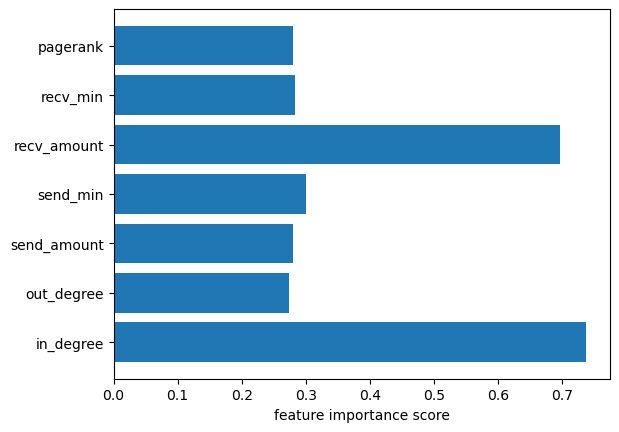

In [32]:
feature_names = ['in_degree', 'out_degree', 'send_amount', 'send_min', 
                 'recv_amount', 'recv_min', 'pagerank']
plt.barh(feature_names, node_feat_mask);
plt.xlabel("feature importance score");

## Conclusion

1. Graph features boost traditional ML model performance. PageRank has the high feature importance score in the xgboost example above.
1. GAT achieves higher accuracy and precision than xgboost.  
2. GAT achieves slightly lower but still good recall compared to xgboost.

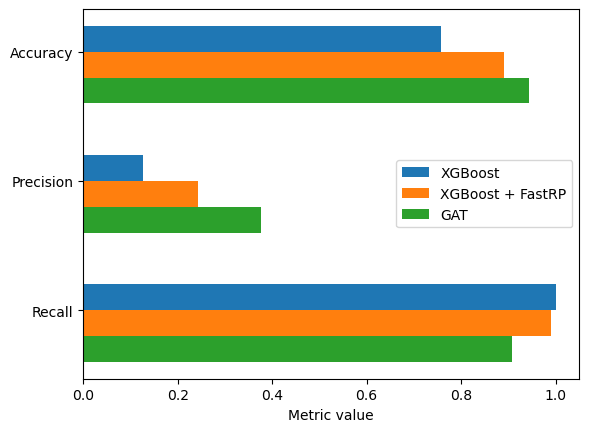

In [33]:
tick_labels = ["Accuracy", "Precision", "Recall"]
x_tree = [metrics['acc_tree'][-1], metrics['prec_tree'][-1], metrics['rec_tree'][-1]]
x_gat = [metrics['acc_gnn_val'][-1], metrics['prec_gnn_val'][-1], metrics['rec_gnn_val'][-1]]
x_fastrp_tree = [metrics['acc_fastrp_tree'][-1], metrics['prec_fastrp_tree'][-1], metrics['rec_fastrp_tree'][-1]]
y = np.arange(len(tick_labels))
bar_width = 0.30
plt.barh(y-bar_width/3, x_tree, 0.2, label="XGBoost")
plt.barh(y+bar_width/3, x_fastrp_tree, 0.2, label="XGBoost + FastRP")
plt.barh(y+bar_width, x_gat, 0.2, label="GAT")
plt.yticks(y, tick_labels);
plt.legend();
plt.gca().invert_yaxis();
plt.xlabel("Metric value");